# Temporal sequence classification: CROHME dataset

Dataset:
https://www.cs.rit.edu/~rlaz/files/CROHME+TFD%E2%80%932019.pdf

Objective: 

- Recognize handwriting input sequences (mathematical expression)
- Output sequence of symbols + relations based on Symbol Relation Tree and Writing Order

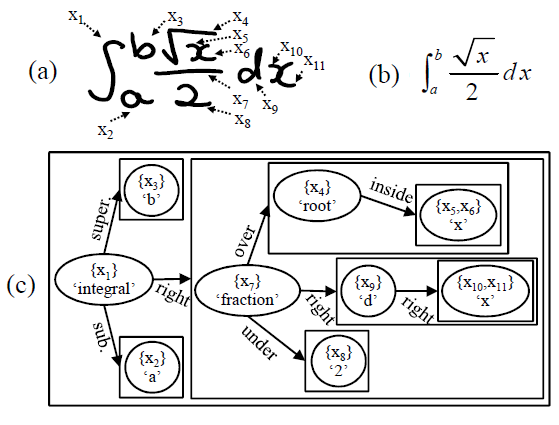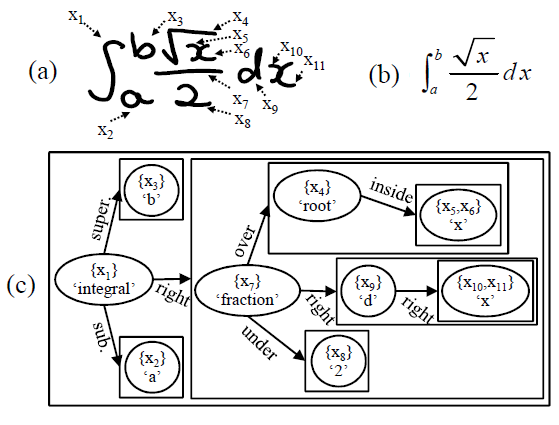

Method:
- Use recurrent neural networks (Bi-directional LSTM).
- Training: supervised learning using pairs of input sequence and target sequence.
- Loss function: CTC loss function to learn temporal classification.
https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html


In [1]:
ls /kaggle/working/lightning_logs/lightning_logs/version_7/checkpoints/epoch=1-val_wer=0.1371.ckpt

ls: cannot access '/kaggle/working/lightning_logs/lightning_logs/version_7/checkpoints/epoch=1-val_wer=0.1371.ckpt': No such file or directory


## Task 1: Dataset & Dataloader

### Overview

We need to build the Dataset class which read the input samples, annotation files and return the pair of <input, target> for each sample.

The target should follow the description of CTC loss function. "Each element in the target sequence is a class index".

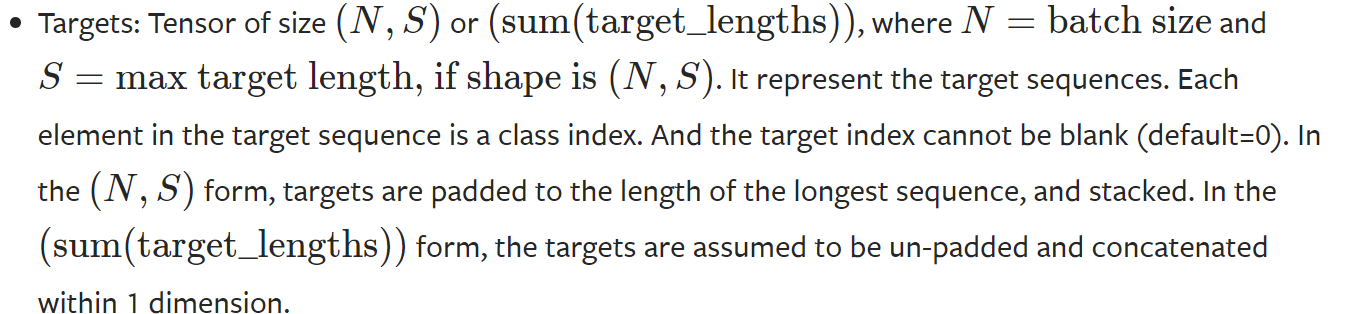


Example:

We have an inkml file: "crohme2019/test/UN19_1041_em_597.inkml"	
Its label is "- Right \sqrt Inside 2"

Target would be: [[5, 50, 35, 51, 12]], where the index here is the index of tokens (from a vocabulary)


### 1.1 Build vocab

The first task is build the vocabulary from the dataset. From the target of the annotation files, extract and unique the token list to get the vocabulary. (Find the set of symbols and relations from labeled dataset).

Input: 

```
/kaggle/input/crohme2019/crohme2019_train.txt
/kaggle/input/crohme2019/crohme2019_valid.txt
/kaggle/input/crohme2019/crohme2019_test.txt
```
Output:
```
crohme_vocab.txt
```

In [2]:
ls /kaggle/working/lightning_logs/lightning_logs/version_6/checkpoints

ls: cannot access '/kaggle/working/lightning_logs/lightning_logs/version_6/checkpoints': No such file or directory


In [1]:
input_files = ['/kaggle/input/crohme2019/crohme2019_train.txt',
'/kaggle/input/crohme2019/crohme2019_valid.txt',
'/kaggle/input/crohme2019/crohme2019_test.txt']

vocab = set()

for input_file in input_files:
    for line in open(input_file).readlines():
        if len(line.strip().split('\t')) == 2:
            vocab.update(line.strip().split('\t')[1].split())


In [2]:
vocab_syms = [v for v in vocab if v not in ['Above', 'Below', 'Inside', 'NoRel', 'Right', 'Sub', 'Sup']]

In [3]:
with open('crohme_vocab.txt', 'w') as f:
    f.writelines([c + '\n' for c in sorted(vocab_syms)])
    f.writelines([c + '\n' for c in ['Above', 'Below', 'Inside', 'NoRel', 'Right', 'Sub', 'Sup']])

#### Vocab class

In [4]:
class Vocab(object):
    def __init__(self, vocab_file=None):
        self.word2index = {}
        self.index2word = {}

        if vocab_file:
            self.load_vocab(vocab_file)
    
    def load_vocab(self, vocab_file):
        # load vocab from file
        with open(vocab_file, 'r') as f:
            for i, line in enumerate(f):
                word = line.strip()
                self.word2index[word] = i
                self.index2word[i] = word
        # add blank word
        self.word2index['<blank>'] = len(self.word2index)
        self.index2word[self.word2index['<blank>']] = '<blank>'
    def encode(self, tokens):
        return [self.word2index[token] for token in tokens]
    
    def decode(self, ids):
        return [self.index2word[id] for id in ids]


In [5]:
vocab = Vocab(vocab_file = '/kaggle/working/crohme_vocab.txt')

In [6]:
## test vocab
vocab = Vocab('crohme_vocab.txt')
input = '- Right \\sqrt Inside 2'.split()
output = [vocab.word2index[word] for word in input]
output
assert output == [4, 105, 66, 103, 9]

### Read an InkML files 

Visualize InkML file
https://www.cs.rit.edu/~rlaz/inkml_viewer/index.xhtml

In [7]:
import numpy as np

import xml.etree.ElementTree as ET

class Segment(object):
    """Class to reprsent a Segment compound of strokes (id) with an id and label."""
    __slots__ = ('id', 'label' ,'strId')
    def __init__(self, *args):
        if len(args) == 3:
            self.id = args[0]
            self.label = args[1]
            self.strId = args[2]
        else:
            self.id = "none"
            self.label = ""
            self.strId = set([])

class Inkml(object):
    """Class to represent an INKML file with strokes, segmentation and labels"""
    __slots__ = ('fileName', 'strokes', 'strkOrder','segments','truth','UI')

    NS = {'ns': 'http://www.w3.org/2003/InkML', 'xml': 'http://www.w3.org/XML/1998/namespace'}

    def __init__(self,*args):
        self.fileName = None
        self.strokes = {}
        self.strkOrder = []
        self.segments = {}
        self.truth = ""
        self.UI = ""
        if len(args) == 1:
            self.fileName = args[0]
            self.loadFromFile()
    
    def fixNS(self,ns,att):
        """Build the right tag or element name with namespace"""
        return '{'+Inkml.NS[ns]+'}'+att

    def loadFromFile(self):
        """load the ink from an inkml file (strokes, segments, labels)"""
        tree = ET.parse(self.fileName)
        # # ET.register_namespace();
        root = tree.getroot()
        for info in root.findall('ns:annotation',namespaces=Inkml.NS):
            if 'type' in info.attrib:
                if info.attrib['type'] == 'truth':
                    self.truth = info.text.strip()
                if info.attrib['type'] == 'UI':
                    self.UI = info.text.strip()
        for strk in root.findall('ns:trace',namespaces=Inkml.NS):
            self.strokes[strk.attrib['id']] = strk.text.strip()
            self.strkOrder.append(strk.attrib['id'])
        segments = root.find('ns:traceGroup',namespaces=Inkml.NS)
        if segments is None or len(segments) == 0:
            return
        for seg in (segments.iterfind('ns:traceGroup',namespaces=Inkml.NS)):
            id = seg.attrib[self.fixNS('xml','id')]
            label = seg.find('ns:annotation',namespaces=Inkml.NS).text
            strkList = set([])
            for t in seg.findall('ns:traceView',namespaces=Inkml.NS):
                strkList.add(t.attrib['traceDataRef'])
            self.segments[id] = Segment(id,label, strkList)
        
    def getTraces(self, height = 256):
        traces_array = [np.array([p.strip().split()[:2] # only get two channels
            for p in self.strokes[id].split(',')], dtype='float') 
              for id in self.strkOrder ]
        
        ratio = height / ((np.concatenate(traces_array, 0).max(0) - np.concatenate(traces_array, 0).min(0))[1] + 1e-6)
        return [(trace * ratio).astype(int).tolist() for trace in traces_array]

In [8]:
ink = Inkml('/kaggle/input/crohme2019/crohme2019/crohme2019/valid/18_em_0.inkml')
[np.array(trace).shape for trace in ink.getTraces()]

[(525, 2),
 (113, 2),
 (118, 2),
 (328, 2),
 (350, 2),
 (96, 2),
 (130, 2),
 (115, 2),
 (293, 2),
 (304, 2),
 (111, 2),
 (133, 2),
 (265, 2),
 (329, 2),
 (103, 2),
 (132, 2)]

> The coordinations of pen traces (x, y) are obtain from collection device, origin at top left position. To visualize, the y coordination need to be inverted.

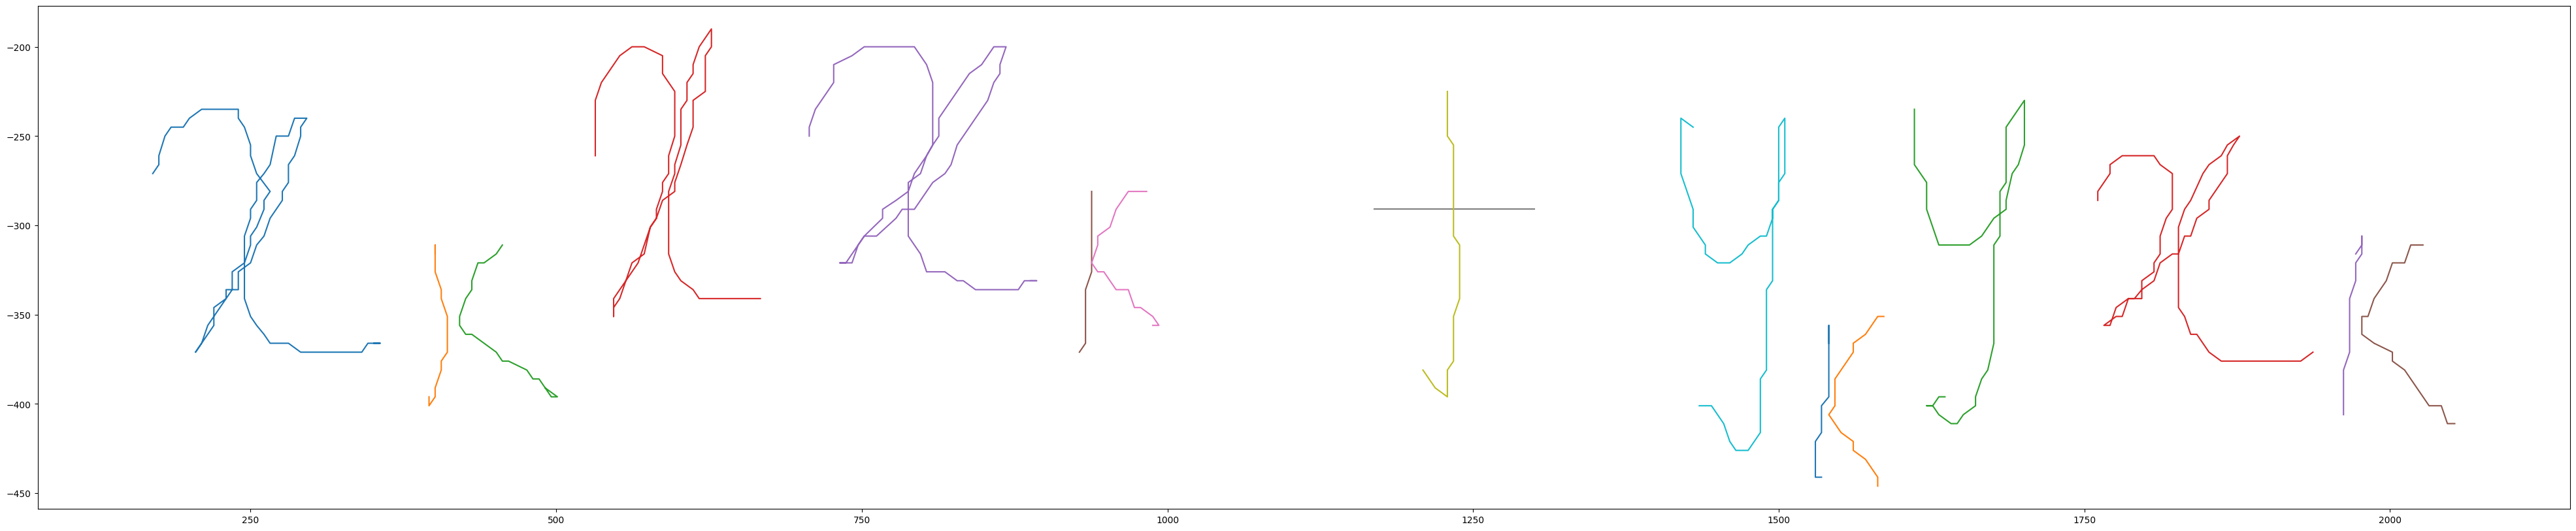

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50,10))
for trace in ink.getTraces():
    trace_arr = np.array(trace)
    plt.plot(trace_arr[:, 0], - trace_arr[:, 1]) # invert y coordinate

### Dataset class

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

- \_\_len\_\_ so that len(dataset) returns the size of the dataset.

- \_\_getitem\_\_ to support the indexing such that dataset[i] can be used to get ith sample.




In [10]:
from torch.utils.data import Dataset
import torch
class InkmlDataset(Dataset):
    def __init__(self, annotation, root_dir, vocab):
        """
        Arguments:
            annotation (string): annotation file
            root_dir (string): Directory with all the images.
        """
        self.annotation = annotation
        self.root_dir = root_dir
        self.vocab = vocab
        
        # load annotations
        self.ink_paths = []
        self.labels = []

        self.ink_paths, self.labels = list(zip(*[line.strip().split('\t') for line in open(self.annotation).readlines() if len(line.strip().split('\t')) == 2]))

    def __len__(self):
        return len(self.labels)

    #main function
    def __getitem__(self, idx):
        inkfile = self.ink_paths[idx]
        label = self.labels[idx]

        ### feature
        # read inkml sample --> traces
        ink = Inkml(self.root_dir + '/' + inkfile)
        traces = ink.getTraces()
        
        # remove consecutive duplicated points -- frequency rate
        traces = [self.remove_duplicate(trace) for trace in traces]            
        
        # extract features (delta_x / distance, delta_y / distance, distance, pen_up)
        feature = self.feature_extraction(traces)
        ### label
        # convert tokens of label into vocab indexes 
        label = np.array([self.vocab.word2index[token] for token in label.split()])
        
        input_len = len(feature)
        label_len = len(label)

        return torch.from_numpy(feature), torch.from_numpy(label), input_len, label_len
    
    def remove_duplicate(self, trace):
        prev = None
        new_trace = []
        for point in trace:
            if (prev != None and point != prev) or prev == None:
                new_trace.append(point)
            prev = point
        return new_trace
    
    def feature_extraction(self, traces):
        trace_lens = list(map(len,traces))
        from itertools import chain
        traces_flatten = chain(*traces)
        traces_flatten = np.array(list(chain(*traces)))
        delta = traces_flatten[1:] - traces_flatten[:-1]
        distance = np.sqrt(np.sum(delta ** 2, axis=-1)) + 1e-10

        pen_up = np.zeros(len(delta))
        pen_up[(np.array(trace_lens).cumsum() -1)[:-1]] = 1

        feature = np.concatenate((delta / np.expand_dims(distance, 1) , np.expand_dims(distance, 1), np.expand_dims(pen_up, 1)), axis = -1)
        return feature


In [11]:
def remove_duplicate(trace):
    prev = None
    new_trace = []
    for point in trace:
        if (prev != None and point != prev) or prev == None:
            new_trace.append(point)
        prev = point
    return new_trace

In [12]:
ink = Inkml('/kaggle/input/crohme2019/crohme2019/crohme2019/valid/18_em_0.inkml')
traces = ink.getTraces()
traces = [remove_duplicate(trace) for trace in traces]

In [13]:
assert list(map(len,traces)) == [82, 16, 21, 78, 82, 15, 18, 18, 28, 58, 15, 19, 56, 70, 18, 21]


In [14]:
def feature_extraction (traces):
    from itertools import chain
    traces_flatten = chain(*traces)
    traces_flatten = np.array(list(chain(*traces)))
    delta = traces_flatten[1:] - traces_flatten[:-1]
    distance = np.sqrt(np.sum(delta ** 2, axis=-1))
    feature = np.concatenate((delta / np.expand_dims(distance, 1) , np.expand_dims(distance, 1)), axis = -1)
    return feature

In [15]:
ink = Inkml('/kaggle/input/crohme2019/crohme2019/crohme2019/valid/18_em_0.inkml')
traces = ink.getTraces()
traces = [remove_duplicate(trace) for trace in traces]
feature = feature_extraction(traces)

import numpy.testing as npt
assert feature.shape == (614, 3)
npt.assert_allclose(feature.mean(axis=0), np.array([ 0.17677799,  0.29519369, 11.35540311]))
npt.assert_allclose(feature.var(axis=0), np.array([3.75390418e-01, 5.06219812e-01, 4.19017361e+02])
)

In [16]:
feature.shape

(614, 3)

In [17]:
def feature_extraction (traces):
    trace_lens = list(map(len,traces))
    from itertools import chain
    traces_flatten = chain(*traces)
    traces_flatten = np.array(list(chain(*traces)))
    delta = traces_flatten[1:] - traces_flatten[:-1]
    distance = np.sqrt(np.sum(delta ** 2, axis=-1))
    
    pen_up = np.zeros(len(delta))
    pen_up[(np.array(trace_lens).cumsum() -1)[:-1]] = 1
    
    feature = np.concatenate((delta / np.expand_dims(distance, 1) , np.expand_dims(distance, 1), np.expand_dims(pen_up, 1)), axis = -1)
    return feature

In [18]:
ink = Inkml('/kaggle/input/crohme2019/crohme2019/crohme2019/valid/18_em_0.inkml')
traces = ink.getTraces()
traces = [remove_duplicate(trace) for trace in traces]
feature = feature_extraction(traces)

import numpy.testing as npt
assert feature.shape == (614, 4)
npt.assert_array_equal(np.where(feature[:,3] == 1)[0], np.array([ 81,  97, 118, 196, 278, 293, 311, 329, 357, 415, 430, 449, 505,
       575, 593]))


In [19]:
dataset = InkmlDataset(annotation='/kaggle/input/crohme2019/crohme2019_valid.txt', root_dir='/kaggle/input/crohme2019/crohme2019', vocab=Vocab('crohme_vocab.txt'))
feature, label, input_len, label_len = dataset.__getitem__(0)

import numpy.testing as npt

assert type(feature) == torch.Tensor
assert type(label) == torch.Tensor
assert feature.shape == (231, 4)
npt.assert_array_equal(label, np.array([59, 105, 1, 105, 59, 105, 1, 105, 87, 105, 2, 105, 2]))
assert input_len == 231
assert label_len == 13

### Dataloader

Write the dataloader with custom collate function to pad the input and target sequence

In [20]:
from torch.nn.utils.rnn import pad_sequence
import torch

def collate_fn(batch):
    features = []
    labels = []
    input_lens = []
    label_lens = []

    for feature, label, input_len, label_len in batch:
        features.append(feature)
        labels.append(label)
        input_lens.append(input_len)
        label_lens.append(label_len)

    features = pad_sequence(features, batch_first=True)
    labels = pad_sequence(labels, batch_first=True)
    input_lens = torch.from_numpy(np.array(input_lens))
    label_lens = torch.from_numpy(np.array(label_lens))
    return features, labels, input_lens, label_lens

In [21]:
# test collate_fn
features, labels, input_lens, label_lens = collate_fn([dataset[0], dataset[1]])

import numpy.testing as npt


assert type(input_lens) == torch.Tensor
assert type(label_lens) == torch.Tensor

assert features.shape == (2, 231, 4)
assert labels.shape == (2, 13)
npt.assert_array_equal(input_lens.numpy(), np.array([231, 102])) 
npt.assert_array_equal(label_lens, np.array([13, 5]))

In [22]:
# test collate_fn with data loader
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

features, labels, input_lens, label_lens = next(iter(data_loader))
assert features.shape == (2, 231, 4)
assert labels.shape == (2, 13)
npt.assert_array_equal(input_lens.numpy(), np.array([231, 102])) 
npt.assert_array_equal(label_lens, np.array([13, 5]))

### Pytorch lightning datamodule

https://lightning.ai/docs/pytorch/stable/data/datamodule.html

#### Data module

In [23]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class CROHMEDatamodule(pl.LightningDataModule):
    def __init__(self, root_dir, train_annotation, validation_annotation, test_annotation, vocab_file, batch_size, num_workers):
        super().__init__()
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.train_annotation = train_annotation
        self.validation_annotation = validation_annotation
        self.test_annotation = test_annotation
        self.vocab = Vocab(vocab_file)
        self.num_workers=num_workers

    def setup(self, stage: str):
        self.train_dataset = InkmlDataset(self.train_annotation, self.root_dir, self.vocab)
        self.val_dataset = InkmlDataset(self.validation_annotation, self.root_dir, self.vocab)
        self.test_dataset = InkmlDataset(self.test_annotation, self.root_dir, self.vocab)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True, collate_fn=collate_fn)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False, collate_fn=collate_fn)

    def test_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False, collate_fn=collate_fn)

## Model

Check out this tutorial
https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

In [24]:
# build a model of LSTM 3 x 128
import torch.nn as nn
class LSTM_TemporalClassification(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        # declare layers
        super(LSTM_TemporalClassification, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        
    def forward(self, x):
        # write calculation process here
        x, _ = self.lstm(x)
        x = self.fc(x)       
        
        return x
        

In [25]:
model = LSTM_TemporalClassification(4, 128, 3, 109)
assert model.forward(torch.rand((10, 100, 4))).shape == (10, 100, 109)

### Loss: CTC

Read the documentation of CTC loss
https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html

What is the role of `input_lengths`, `target_lengths`

```
loss = nn.CTCLoss()(input, target, input_lengths, target_lengths)
```

### Pytorch lightning Module

https://lightning.ai/docs/pytorch/stable/common/lightning_module.html

A LightningModule organizes your PyTorch code into 6 sections:

Initialization (\_\_init\_\_ and setup()).
Train Loop (training_step())
Validation Loop (validation_step())
Test Loop (test_step())
Prediction Loop (predict_step())
Optimizers and LR Schedulers (configure_optimizers())

An example of a LightningModule


> **Task: Complete the implementation**

In [26]:
import pytorch_lightning as pl
import torch

class MathOnlineModel(pl.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.model = LSTM_TemporalClassification(4, 128, 3, 109)
        self.criterion = nn.CTCLoss(blank=108)
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        # your code here
        x_hat = self.model(x.float())
        loss = self.criterion(x_hat.log_softmax(-1).permute(1, 0, 2), y, x_lens, y_lens)
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        # your code here
        x_hat = self.model(x.float())
        loss = self.criterion(x_hat.log_softmax(-1).permute(1, 0, 2), y, x_lens, y_lens)
        self.log('val_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        # your code here
        x_hat = self.model(x.float())
        loss = self.criterion(x_hat.log_softmax(-1).permute(1, 0, 2), y, x_lens, y_lens)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.001)

## Trainer (pytorch lightning)

In [27]:
import wandb
wandb.init(project='pt-lightning', name='crohme')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Example of a trainer class

In [29]:
!pip install --upgrade  ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 92.6 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 77.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: httpx
    Found existing installation: httpx 0.27.0
    Uninstalling httpx-0.27.0:
      Succ

In [ ]:
!pip install --upgrade beatrix_jupyterlab @jupyterlab/git nbdime-jupyterlab
!jupyter labextension install @jupyterlab/git

In [34]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

trainer = Trainer(
    callbacks = [
        LearningRateMonitor(logging_interval='step'),
        ModelCheckpoint(filename='{epoch}-{val_loss:.4f}', save_top_k=5, monitor='val_loss', mode='min'),
    ], 
    logger = pl.loggers.WandbLogger(),
    check_val_every_n_epoch=1,
    fast_dev_run=False,
    default_root_dir='checkpoint',
    deterministic=False, 
    max_epochs=10, 
    log_every_n_steps=50,
    devices = 1,
)
model = MathOnlineModel()
#model = MathOnlineModel.load_from_checkpoint('lightning_logs/lightning_logs/version_7/checkpoints/epoch=2-val_wer=0.1382.ckpt')

dm = CROHMEDatamodule(root_dir='/kaggle/input/crohme2019/crohme2019', 
                       train_annotation='/kaggle/input/crohme2019/crohme2019_train.txt', 
                       validation_annotation='/kaggle/input/crohme2019/crohme2019_valid.txt', 
                       test_annotation='/kaggle/input/crohme2019/crohme2019_test.txt', 
                       vocab_file='crohme_vocab.txt', 
                       batch_size=32,
                      num_workers=4
                     )

trainer.fit(model, dm)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [35]:
from typing import List
import torch
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.vocab = vocab
        self.blank = vocab.word2index['<blank>']

    def forward(self, emission: torch.Tensor) -> List[str]:
        """Given a sequence emission over labels, get the best path
        Args:
          emission (Tensor): Logit tensors. Shape `[seq_len, num_label]`.

        Returns:
          List[str]: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1).numpy()
        indices = [i for i in indices if i != self.blank]
        return self.vocab.decode(indices)

greedy_decoder = GreedyCTCDecoder(vocab)

Revise version for bonus 1

In [69]:
class GreedyCTCDecoder(nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.vocab = vocab
        self.blank = self.vocab.word2index['<blank>']

    def forward(self, emission):
        """
        Given a sequence emission over labels, get the best path

        Args:
          emission (Tensor): Logit tensors of shape `[batch, time, num_class]` or `[time, num_class]`
                             If it's `[batch, time, num_class]`, you might need to iterate batch-wise or adjust code accordingly.
        Returns:
          List of sequences: The resulting transcripts as a list of tokens.
        """
        # If emission is [batch, time, num_class], handle batch dimension.
        # Let's assume emission is [batch, time, num_class]
        # If it's [time, num_class], you'd remove the for loop and just process directly.
        all_transcripts = []
        for batch_idx in range(emission.size(0)):
            # Take the slice of this batch
            single_emission = emission[batch_idx]  # [time, num_class]

            # Get the max indices along the class dimension
            indices = torch.argmax(single_emission, dim=-1)  # [time]
            # Remove consecutive duplicates
            indices = torch.unique_consecutive(indices, dim=-1)
            # Move to CPU before calling numpy
            indices = indices.cpu().numpy()
            # Filter out the blank
            indices = [i for i in indices if i != self.blank]
            # Decode tokens to symbols
            transcript = self.vocab.decode(indices)
            all_transcripts.append(transcript)

        return all_transcripts

In [37]:
!ls /kaggle/working/lightning_logs

gz5dk4zp


In [38]:
!ls /kaggle/working/lightning_logs/gz5dk4zp

checkpoints


In [39]:
!ls /kaggle/working/lightning_logs/gz5dk4zp/checkpoints

'epoch=5-val_loss=3.3830.ckpt'	'epoch=7-val_loss=2.9879.ckpt'
'epoch=5-val_loss=3.4192.ckpt'	'epoch=8-val_loss=1.9828.ckpt'
'epoch=5-val_loss=3.4615.ckpt'	'epoch=8-val_loss=2.4123.ckpt'
'epoch=6-val_loss=2.7892.ckpt'	'epoch=8-val_loss=2.4750.ckpt'
'epoch=6-val_loss=3.0877.ckpt'	'epoch=9-val_loss=1.7489.ckpt'
'epoch=6-val_loss=3.3263.ckpt'	'epoch=9-val_loss=2.0583.ckpt'
'epoch=7-val_loss=2.3631.ckpt'	'epoch=9-val_loss=2.0643.ckpt'
'epoch=7-val_loss=2.7241.ckpt'


In [40]:
model = MathOnlineModel.load_from_checkpoint('lightning_logs/gz5dk4zp/checkpoints/epoch=9-val_loss=1.7489.ckpt')
model.eval()

dataset = InkmlDataset(annotation='/kaggle/input/crohme2019/crohme2019_valid.txt', root_dir='/kaggle/input/crohme2019/crohme2019', vocab=Vocab('crohme_vocab.txt'))
feature, label, input_len, label_len = dataset.__getitem__(0)

output = model.forward(feature.unsqueeze(0).cuda().float()).detach().squeeze().cpu()
greedy_decoder.forward(output), vocab.decode(label.numpy())


(['3',
  'Right',
  '(',
  'Right',
  '3',
  'Right',
  '(',
  'Right',
  'n',
  'Right',
  ')',
  'Right',
  ')'],
 ['\\phi',
  'Right',
  '(',
  'Right',
  '\\phi',
  'Right',
  '(',
  'Right',
  'n',
  'Right',
  ')',
  'Right',
  ')'])

In [ ]:
!ls /kaggle/working/lightning_logs/lightning_logs/version_7/checkpoints

In [ ]:
# !rm -r lightning_logs/lightning_logs/version_4

#### Debug with fast_dev_run

- Set fast_dev_run=True and check if there are any bug exist.

#### Inference

The output of networks need to process by a decoding step.

- Greedy decode

In [42]:
import pytorch_lightning as pl
import torch
from torchmetrics.functional.text.helper import _LevenshteinEditDistance as _LE_distance

class MathOnlineModel(pl.LightningModule):
    def __init__(self, lr=0.001, input_size=4, output_size=109, hidden_size=128, num_layers = 3, decoder=None):
        super().__init__()
        self.model = LSTM_TemporalClassification(input_size, hidden_size, num_layers, output_size)
        self.criterion = nn.CTCLoss(blank=output_size - 1)
        self.lr = lr
        self.decoder = decoder
        
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        # your code here
        x_hat = self.model(x.float())
        loss = self.criterion(x_hat.log_softmax(-1).permute(1, 0, 2), y, x_lens, y_lens)
        
        total_edits = 0
        total_lens = 0
        for seq, y_seq, y_len in zip(x_hat.detach().cpu(), y, y_lens):
            label = y_seq[:y_len].cpu().numpy()
            edit_distance, _ = _LE_distance(vocab.decode(label))(greedy_decoder.forward(seq))
            total_edits += edit_distance
            total_lens += y_len
            
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_wer', total_edits / total_lens, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        # your code here
        x_hat = self.model(x.float())
        loss = self.criterion(x_hat.log_softmax(-1).permute(1, 0, 2), y, x_lens, y_lens)
        total_edits = 0
        total_lens = 0
        for seq, y_seq, y_len in zip(x_hat.detach().cpu(), y, y_lens):
            label = y_seq[:y_len].cpu().numpy()
            edit_distance, _ = _LE_distance(vocab.decode(label))(greedy_decoder.forward(seq))
            total_edits += edit_distance
            total_lens += y_len
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_wer', total_edits / total_lens, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        # your code here
        x_hat = self.model(x.float())
        loss = self.criterion(x_hat.log_softmax(-1).permute(1, 0, 2), y, x_lens, y_lens)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

#### Add calulation of metrics (accuracy, loss) during validation and test

- Edit distance: calculate edit distance between output and target.

https://lightning.ai/docs/torchmetrics/stable/text/edit.html

In [43]:
from torchmetrics.functional.text.helper import _LevenshteinEditDistance as _LE_distance
_LE_distance([vocab.index2word[i.item()] for i in label])(greedy_decoder.forward(output)) 

(2,
 (<_EditOperations.OP_SUBSTITUTE: 'substitute'>,
  <_EditOperations.OP_NOTHING: 'nothing'>,
  <_EditOperations.OP_NOTHING: 'nothing'>,
  <_EditOperations.OP_NOTHING: 'nothing'>,
  <_EditOperations.OP_SUBSTITUTE: 'substitute'>,
  <_EditOperations.OP_NOTHING: 'nothing'>,
  <_EditOperations.OP_NOTHING: 'nothing'>,
  <_EditOperations.OP_NOTHING: 'nothing'>,
  <_EditOperations.OP_NOTHING: 'nothing'>,
  <_EditOperations.OP_NOTHING: 'nothing'>,
  <_EditOperations.OP_NOTHING: 'nothing'>,
  <_EditOperations.OP_NOTHING: 'nothing'>,
  <_EditOperations.OP_NOTHING: 'nothing'>))

In [46]:
from torchmetrics.functional.text.helper import _LevenshteinEditDistance 

def edit_distance(pred_seq, label_seq):
    distance, _ = _LevenshteinEditDistance(label_seq)(pred_seq)
    return distance

# Test your implementation
assert edit_distance(['\\phi',
  'Right',
  '(',
  'Right',
  '0',
  'Right',
  '(',
  'Right',
  'n',
  'Right',
  ')',
  'Right',
  ')'],
 ['\\phi',
  'Right',
  '(',
  'Right',
  '\\phi',
  'Right',
  '(',
  'Right',
  'n',
  'Right',
  ')',
  'Right',
  ')']) == 1

# Bonus 1 (+1 pts for final exam)

Add metrics to evaluate accuracy of symbols and relations separately


In [48]:
# Define relations based on your vocab
RELATIONS = ['Above', 'Below', 'Inside', 'NoRel', 'Right', 'Sub', 'Sup']
SYMBOLS = [token for token in vocab.word2index.keys() if token not in RELATIONS and token != '<blank>']

In [72]:
"""from torchmetrics import Accuracy

class MathOnlineModel(pl.LightningModule):
    def __init__(self, lr=0.001, vocab=None):
        super().__init__()
        assert vocab is not None, "Vocab must be provided"
        self.model = LSTM_TemporalClassification(
            input_size=4, 
            hidden_size=128, 
            num_layers=3, 
            num_classes=len(vocab.word2index)
        )
        self.criterion = nn.CTCLoss(blank=vocab.word2index['<blank>'])
        self.lr = lr
        self.vocab = vocab
        self.relations = ['Above', 'Below', 'Inside', 'NoRel', 'Right', 'Sub', 'Sup']
        self.symbols = [token for token in vocab.word2index.keys() if token not in self.relations and token != '<blank>']
        
        # Initialize metrics with task and num_classes
        self.train_symbol_acc = Accuracy(task='multiclass', num_classes=len(self.symbols))
        self.val_symbol_acc = Accuracy(task='multiclass', num_classes=len(self.symbols))
        self.test_symbol_acc = Accuracy(task='multiclass', num_classes=len(self.symbols))
        
        self.train_relation_acc = Accuracy(task='multiclass', num_classes=len(self.relations))
        self.val_relation_acc = Accuracy(task='multiclass', num_classes=len(self.relations))
        self.test_relation_acc = Accuracy(task='multiclass', num_classes=len(self.relations))
        
        self.decoder = GreedyCTCDecoder(vocab)
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        x_hat = self.model(x.float())
        loss = self.criterion(
            x_hat.log_softmax(-1).permute(1, 0, 2), 
            y, 
            x_lens, 
            y_lens
        )
        
        # Decode predictions
        preds = self.decoder(x_hat)
        targets = self.vocab.decode(y.cpu().numpy())
        
        # Extract symbols and relations
        pred_symbols = []
        target_symbols = []
        pred_relations = []
        target_relations = []
        
        for pred_seq, target_seq in zip(preds, targets):
            pred_symbols.extend([token for token in pred_seq if token in self.symbols])
            target_symbols.extend([token for token in target_seq if token in self.symbols])
            pred_relations.extend([token for token in pred_seq if token in self.relations])
            target_relations.extend([token for token in target_seq if token in self.relations])
        
        # Convert tokens to indices relative to symbols and relations
        pred_symbols_indices = [self.symbols.index(token) for token in pred_symbols]
        target_symbols_indices = [self.symbols.index(token) for token in target_symbols]
        pred_relations_indices = [self.relations.index(token) for token in pred_relations]
        target_relations_indices = [self.relations.index(token) for token in target_relations]
        
        # Convert to tensors
        pred_symbols_tensor = torch.tensor(pred_symbols_indices, dtype=torch.long, device=self.device)
        target_symbols_tensor = torch.tensor(target_symbols_indices, dtype=torch.long, device=self.device)
        pred_relations_tensor = torch.tensor(pred_relations_indices, dtype=torch.long, device=self.device)
        target_relations_tensor = torch.tensor(target_relations_indices, dtype=torch.long, device=self.device)
        
        # Compute accuracies
        if len(target_symbols_tensor) > 0:
            self.train_symbol_acc(pred_symbols_tensor, target_symbols_tensor)
        if len(target_relations_tensor) > 0:
            self.train_relation_acc(pred_relations_tensor, target_relations_tensor)
        
        # Log metrics
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_symbol_acc', self.train_symbol_acc, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_relation_acc', self.train_relation_acc, prog_bar=True, on_step=True, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        x_hat = self.model(x.float())
        loss = self.criterion(
            x_hat.log_softmax(-1).permute(1, 0, 2), 
            y, 
            x_lens, 
            y_lens
        )
        
        # Decode predictions
        preds = self.decoder(x_hat)
        targets = self.vocab.decode(y.cpu().numpy())
        
        # Extract symbols and relations
        pred_symbols = []
        target_symbols = []
        pred_relations = []
        target_relations = []
        
        for pred_seq, target_seq in zip(preds, targets):
            pred_symbols.extend([token for token in pred_seq if token in self.symbols])
            target_symbols.extend([token for token in target_seq if token in self.symbols])
            pred_relations.extend([token for token in pred_seq if token in self.relations])
            target_relations.extend([token for token in target_seq if token in self.relations])
        
        # Convert tokens to indices relative to symbols and relations
        pred_symbols_indices = [self.symbols.index(token) for token in pred_symbols]
        target_symbols_indices = [self.symbols.index(token) for token in target_symbols]
        pred_relations_indices = [self.relations.index(token) for token in pred_relations]
        target_relations_indices = [self.relations.index(token) for token in target_relations]
        
        # Convert to tensors
        pred_symbols_tensor = torch.tensor(pred_symbols_indices, dtype=torch.long, device=self.device)
        target_symbols_tensor = torch.tensor(target_symbols_indices, dtype=torch.long, device=self.device)
        pred_relations_tensor = torch.tensor(pred_relations_indices, dtype=torch.long, device=self.device)
        target_relations_tensor = torch.tensor(target_relations_indices, dtype=torch.long, device=self.device)
        
        # Compute accuracies
        if len(target_symbols_tensor) > 0:
            self.val_symbol_acc(pred_symbols_tensor, target_symbols_tensor)
        if len(target_relations_tensor) > 0:
            self.val_relation_acc(pred_relations_tensor, target_relations_tensor)
        
        # Log metrics
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_symbol_acc', self.val_symbol_acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_relation_acc', self.val_relation_acc, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        x_hat = self.model(x.float())
        loss = self.criterion(
            x_hat.log_softmax(-1).permute(1, 0, 2), 
            y, 
            x_lens, 
            y_lens
        )
        
        # Decode predictions
        preds = self.decoder(x_hat)
        targets = self.vocab.decode(y.cpu().numpy())
        
        # Extract symbols and relations
        pred_symbols = []
        target_symbols = []
        pred_relations = []
        target_relations = []
        
        for pred_seq, target_seq in zip(preds, targets):
            pred_symbols.extend([token for token in pred_seq if token in self.symbols])
            target_symbols.extend([token for token in target_seq if token in self.symbols])
            pred_relations.extend([token for token in pred_seq if token in self.relations])
            target_relations.extend([token for token in target_seq if token in self.relations])
        
        # Convert tokens to indices relative to symbols and relations
        pred_symbols_indices = [self.symbols.index(token) for token in pred_symbols]
        target_symbols_indices = [self.symbols.index(token) for token in target_symbols]
        pred_relations_indices = [self.relations.index(token) for token in pred_relations]
        target_relations_indices = [self.relations.index(token) for token in target_relations]
        
        # Convert to tensors
        pred_symbols_tensor = torch.tensor(pred_symbols_indices, dtype=torch.long, device=self.device)
        target_symbols_tensor = torch.tensor(target_symbols_indices, dtype=torch.long, device=self.device)
        pred_relations_tensor = torch.tensor(pred_relations_indices, dtype=torch.long, device=self.device)
        target_relations_tensor = torch.tensor(target_relations_indices, dtype=torch.long, device=self.device)
        
        # Compute accuracies
        if len(target_symbols_tensor) > 0:
            self.test_symbol_acc(pred_symbols_tensor, target_symbols_tensor)
        if len(target_relations_tensor) > 0:
            self.test_relation_acc(pred_relations_tensor, target_relations_tensor)
        
        # Log metrics
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_symbol_acc', self.test_symbol_acc, prog_bar=True)
        self.log('test_relation_acc', self.test_relation_acc, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)
"""

In [83]:
from torchmetrics.text import CharErrorRate  # Updated import path
import torch
import torch.nn as nn
import pytorch_lightning as pl

class GreedyCTCDecoder(nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.vocab = vocab
        self.blank = self.vocab.word2index['<blank>']

    def forward(self, emission):
        """
        Given a batch of emission sequences over labels, get the best path.

        Args:
          emission (Tensor): Logit tensors of shape `[batch, time, num_class]`.

        Returns:
          List[str]: The resulting transcripts as a list of strings.
        """
        all_transcripts = []
        batch_size = emission.size(0)
        for batch_idx in range(batch_size):
            single_emission = emission[batch_idx]  # [time, num_class]

            # Get the max indices along the class dimension
            indices = torch.argmax(single_emission, dim=-1)  # [time]

            # Remove consecutive duplicates
            indices = torch.unique_consecutive(indices, dim=-1)

            # Move to CPU before calling numpy
            indices = indices.cpu().numpy()

            # Filter out the blank
            indices = [i for i in indices if i != self.blank]

            # Decode tokens to symbols
            transcript = self.vocab.decode(indices)
            all_transcripts.append(' '.join(transcript))  # Join tokens into a single string for WER

        return all_transcripts

class MathOnlineModel(pl.LightningModule):
    def __init__(self, lr=0.001, vocab=None):
        super().__init__()
        assert vocab is not None, "Vocab must be provided"
        self.model = LSTM_TemporalClassification(
            input_size=4, 
            hidden_size=128, 
            num_layers=3, 
            num_classes=len(vocab.word2index)
        )
        self.criterion = nn.CTCLoss(blank=vocab.word2index['<blank>'])
        self.lr = lr
        self.vocab = vocab
        self.relations = ['Above', 'Below', 'Inside', 'NoRel', 'Right', 'Sub', 'Sup']
        self.symbols = [token for token in vocab.word2index.keys() if token not in self.relations and token != '<blank>']
        
        self.decoder = GreedyCTCDecoder(vocab)
        
        # Initialize WER metric
        self.train_wer = CharErrorRate()
        self.val_wer = CharErrorRate()
        self.test_wer = CharErrorRate()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        x_hat = self.model(x.float())
        loss = self.criterion(
            x_hat.log_softmax(-1).permute(1, 0, 2), 
            y, 
            x_lens, 
            y_lens
        )
        
        # Decode predictions
        preds = self.decoder(x_hat)
        
        # Decode targets: Convert each target sequence to string
        targets = [' '.join(self.vocab.decode(seq[:length])) for seq, length in zip(y.cpu().numpy(), y_lens)]
        
        # Compute WER
        wer = self.train_wer(preds, targets)
        
        # Log metrics
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_wer', wer, prog_bar=True, on_step=True, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        x_hat = self.model(x.float())
        loss = self.criterion(
            x_hat.log_softmax(-1).permute(1, 0, 2), 
            y, 
            x_lens, 
            y_lens
        )
        
        # Decode predictions
        preds = self.decoder(x_hat)
        
        # Decode targets: Convert each target sequence to string
        targets = [' '.join(self.vocab.decode(seq[:length])) for seq, length in zip(y.cpu().numpy(), y_lens)]
        
        # Compute WER
        wer = self.val_wer(preds, targets)
        
        # Log metrics
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_wer', wer, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        x_hat = self.model(x.float())
        loss = self.criterion(
            x_hat.log_softmax(-1).permute(1, 0, 2), 
            y, 
            x_lens, 
            y_lens
        )
        
        # Decode predictions
        preds = self.decoder(x_hat)
        
        # Decode targets: Convert each target sequence to string
        targets = [' '.join(self.vocab.decode(seq[:length])) for seq, length in zip(y.cpu().numpy(), y_lens)]
        
        # Compute WER
        wer = self.test_wer(preds, targets)
        
        # Log metrics
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_wer', wer, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)


In [ ]:
logger = pl.loggers.WandbLogger(),

In [84]:
# Initialize Vocab
vocab = Vocab('crohme_vocab.txt')

# Initialize DataModule
dm = CROHMEDatamodule(
    root_dir='/kaggle/input/crohme2019/crohme2019',
    train_annotation='/kaggle/input/crohme2019/crohme2019_train.txt',
    validation_annotation='/kaggle/input/crohme2019/crohme2019_valid.txt',
    test_annotation='/kaggle/input/crohme2019/crohme2019_test.txt',
    vocab_file='crohme_vocab.txt',
    batch_size=32,
    num_workers=4
)

# Initialize the Model
model = MathOnlineModel(vocab=vocab)

# Initialize Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

trainer = Trainer(
    callbacks = [
        LearningRateMonitor(logging_interval='step'),
        ModelCheckpoint(
            filename='{epoch}-{val_loss:.4f}', 
            save_top_k=5, 
            monitor='val_loss', 
            mode='min'
        ),
    ], 
    logger = pl.loggers.WandbLogger(),
    check_val_every_n_epoch=1,
    fast_dev_run=False,  # Set to True for quick testing
    default_root_dir='checkpoint',
    deterministic=False, 
    max_epochs=10, 
    log_every_n_steps=50,
    devices=1,  # Adjust based on your hardware
)

# Train the Model
trainer.fit(model, dm)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Bonus 2 (+1 pts for final exam)

Modify loss function to constrain the output of relations at the timestep of pen-up. 

The idea: Provide a masked sequence such that the position of pen-up is masked, the additional loss would penaltize all the relations output to the timestep that has been masked. 


Xây Dựng Từ Vựng (Vocabulary)

In [102]:
# Cell 1: Xây dựng từ vựng từ các file annotation

input_files = [
    '/kaggle/input/crohme2019/crohme2019_train.txt',
    '/kaggle/input/crohme2019/crohme2019_valid.txt',
    '/kaggle/input/crohme2019/crohme2019_test.txt'
]

vocab = set()

for input_file in input_files:
    with open(input_file, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                tokens = parts[1].split()
                vocab.update(tokens)

# Phân loại các ký hiệu và quan hệ
vocab_syms = [v for v in vocab if v not in ['Above', 'Below', 'Inside', 'NoRel', 'Right', 'Sub', 'Sup']]
relations = ['Above', 'Below', 'Inside', 'NoRel', 'Right', 'Sub', 'Sup']

# Ghi từ vựng vào file
with open('crohme_vocab.txt', 'w') as f:
    for token in sorted(vocab_syms):
        f.write(token + '\n')
    for rel in relations:
        f.write(rel + '\n')

print("Vocabulary has been written to 'crohme_vocab.txt'")


Vocabulary has been written to 'crohme_vocab.txt'


Định Nghĩa Lớp Vocab

In [103]:
# Cell 2: Định nghĩa lớp Vocab

class Vocab(object):
    def __init__(self, vocab_file=None):
        self.word2index = {}
        self.index2word = {}
        self.pad_token = '<pad>'
        self.blank_token = '<blank>'
        self.unk_token = '<unk>'

        if vocab_file:
            self.load_vocab(vocab_file)
        
    def load_vocab(self, vocab_file):
        # Load từ vựng từ file
        with open(vocab_file, 'r') as f:
            for i, line in enumerate(f):
                word = line.strip()
                self.word2index[word] = i
                self.index2word[i] = word
        # Thêm các token đặc biệt
        self.word2index[self.pad_token] = len(self.word2index)
        self.index2word[len(self.word2index) -1] = self.pad_token

        self.word2index[self.blank_token] = len(self.word2index)
        self.index2word[len(self.word2index) -1] = self.blank_token

        self.word2index[self.unk_token] = len(self.word2index)
        self.index2word[len(self.word2index) -1] = self.unk_token

    def encode(self, tokens):
        return [self.word2index.get(token, self.word2index[self.unk_token]) for token in tokens]
    
    def decode(self, ids):
        return [self.index2word.get(id, self.unk_token) for id in ids]

Định Nghĩa Lớp Inkml và Segment để Phân Tích File InkML

In [104]:
# Cell 3: Định nghĩa các lớp để phân tích file InkML

import numpy as np
import xml.etree.ElementTree as ET

class Segment(object):
    """Class to represent a Segment compound of strokes (id) with an id and label."""
    __slots__ = ('id', 'label', 'strId')
    
    def __init__(self, id="none", label="", strId=set()):
        self.id = id
        self.label = label
        self.strId = strId

class Inkml(object):
    """Class to represent an InkML file with strokes, segmentation and labels"""
    __slots__ = ('fileName', 'strokes', 'strkOrder', 'segments', 'truth', 'UI')

    NS = {'ns': 'http://www.w3.org/2003/InkML', 'xml': 'http://www.w3.org/XML/1998/namespace'}

    def __init__(self, file_path=None):
        self.fileName = None
        self.strokes = {}
        self.strkOrder = []
        self.segments = {}
        self.truth = ""
        self.UI = ""
        if file_path:
            self.fileName = file_path
            self.loadFromFile()

    def fixNS(self, ns, att):
        """Build the right tag or element name with namespace"""
        return '{' + self.NS[ns] + '}' + att

    def loadFromFile(self):
        """Load the ink from an inkml file (strokes, segments, labels)"""
        tree = ET.parse(self.fileName)
        root = tree.getroot()
        for info in root.findall('ns:annotation', namespaces=self.NS):
            if 'type' in info.attrib:
                if info.attrib['type'] == 'truth':
                    self.truth = info.text.strip()
                if info.attrib['type'] == 'UI':
                    self.UI = info.text.strip()
        for strk in root.findall('ns:trace', namespaces=self.NS):
            self.strokes[strk.attrib['id']] = strk.text.strip()
            self.strkOrder.append(strk.attrib['id'])
        segments = root.find('ns:traceGroup', namespaces=self.NS)
        if segments is not None:
            for seg in segments.iterfind('ns:traceGroup', namespaces=self.NS):
                id = seg.attrib[self.fixNS('xml','id')]
                label = seg.find('ns:annotation', namespaces=self.NS).text
                strkList = set()
                for t in seg.findall('ns:traceView', namespaces=self.NS):
                    strkList.add(t.attrib['traceDataRef'])
                self.segments[id] = Segment(id, label, strkList)

    def getTraces(self, height=256):
        """Get pen traces scaled to the specified height"""
        traces_array = [np.array([p.strip().split()[:2] for p in self.strokes[id].split(',')], dtype='float') for id in self.strkOrder]
        all_points = np.concatenate(traces_array, 0)
        min_y = all_points[:,1].min()
        max_y = all_points[:,1].max()
        ratio = height / ((max_y - min_y) + 1e-6)
        scaled_traces = [(trace * ratio).astype(int).tolist() for trace in traces_array]
        return scaled_traces

# Ví dụ về việc sử dụng lớp Inkml để đọc một file InkML
# ink = Inkml('/kaggle/input/crohme2019/crohme2019/crohme2019/valid/18_em_0.inkml')
# print([np.array(trace).shape for trace in ink.getTraces()])


 Định Nghĩa Lớp InkmlDataset

In [105]:
# Cell 4: Định nghĩa lớp InkmlDataset

from torch.utils.data import Dataset
import torch
import numpy as np

class InkmlDataset(Dataset):
    def __init__(self, annotation, root_dir, vocab):
        """
        Arguments:
            annotation (string): annotation file
            root_dir (string): Directory with all the InkML files.
            vocab (Vocab): Vocabulary object
        """
        self.annotation = annotation
        self.root_dir = root_dir
        self.vocab = vocab
        
        # Load annotations
        self.ink_paths = []
        self.labels = []

        with open(self.annotation, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    self.ink_paths.append(parts[0])
                    self.labels.append(parts[1])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        inkfile = self.ink_paths[idx]
        label = self.labels[idx]

        # Read InkML and extract features
        ink = Inkml(self.root_dir + '/' + inkfile)
        traces = ink.getTraces()

        # Remove consecutive duplicated points
        traces = [self.remove_duplicate(trace) for trace in traces]            

        # Extract features and pen_up
        feature, pen_up = self.feature_extraction(traces)

        # Convert tokens of label into vocab indexes 
        label = np.array([self.vocab.word2index.get(token, self.vocab.word2index['<unk>']) for token in label.split()])
        
        input_len = len(feature)
        label_len = len(label)

        return torch.from_numpy(feature).float(), torch.from_numpy(label).long(), input_len, label_len, torch.from_numpy(pen_up).float()
    
    def remove_duplicate(self, trace):
        """Remove consecutive duplicate points from a trace"""
        prev = None
        new_trace = []
        for point in trace:
            if (prev is not None and point != prev) or prev is None:
                new_trace.append(point)
            prev = point
        return new_trace
    
    def feature_extraction(self, traces):
        """Extract features and pen_up from traces"""
        trace_lens = list(map(len, traces))
        from itertools import chain
        traces_flatten = list(chain(*traces))
        traces_flatten = np.array(traces_flatten)
        delta = traces_flatten[1:] - traces_flatten[:-1]
        distance = np.sqrt(np.sum(delta ** 2, axis=-1)) + 1e-10
        
        pen_up = np.zeros(len(delta), dtype=np.float32)
        pen_up_positions = (np.array(trace_lens).cumsum() -1)[:-1]
        pen_up[pen_up_positions] = 1.0
        
        feature = np.concatenate((delta / distance[:, None], distance[:, None], pen_up[:, None]), axis=1)
        return feature, pen_up


Định Nghĩa Hàm collate_fn

In [106]:
# Cell 5: Định nghĩa hàm collate_fn

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    features, labels, input_lens, label_lens, pen_ups = zip(*batch)
    
    # Pad sequences
    features_padded = pad_sequence(features, batch_first=True, padding_value=0.0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=vocab.word2index['<blank>'])
    pen_ups_padded = pad_sequence(pen_ups, batch_first=True, padding_value=0.0)
    
    input_lens = torch.tensor(input_lens, dtype=torch.long)
    label_lens = torch.tensor(label_lens, dtype=torch.long)
    
    return features_padded, labels_padded, input_lens, label_lens, pen_ups_padded


Định Nghĩa CROHMEDatamodule

In [107]:
# Cell 6: Định nghĩa DataModule

import pytorch_lightning as pl
from torch.utils.data import DataLoader

class CROHMEDatamodule(pl.LightningDataModule):
    def __init__(self, root_dir, train_annotation, validation_annotation, test_annotation, vocab_file, batch_size, num_workers):
        super().__init__()
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.train_annotation = train_annotation
        self.validation_annotation = validation_annotation
        self.test_annotation = test_annotation
        self.vocab = Vocab(vocab_file)
        self.num_workers = num_workers

    def setup(self, stage: str = None):
        self.train_dataset = InkmlDataset(self.train_annotation, self.root_dir, self.vocab)
        self.val_dataset = InkmlDataset(self.validation_annotation, self.root_dir, self.vocab)
        self.test_dataset = InkmlDataset(self.test_annotation, self.root_dir, self.vocab)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True, collate_fn=collate_fn)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False, collate_fn=collate_fn)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False, collate_fn=collate_fn)


Định Nghĩa GreedyCTCDecoder

In [108]:
# Cell 7: Định nghĩa GreedyCTCDecoder

import torch
import torch.nn as nn

class GreedyCTCDecoder(nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.vocab = vocab
        self.blank = self.vocab.word2index['<blank>']

    def forward(self, emission):
        """
        Given a batch of emission sequences over labels, get the best path.

        Args:
          emission (Tensor): Logit tensors of shape `[batch, time, num_class]`.

        Returns:
          List[str]: The resulting transcripts as a list of strings.
        """
        all_transcripts = []
        batch_size = emission.size(0)
        for batch_idx in range(batch_size):
            single_emission = emission[batch_idx]  # [time, num_class]

            # Get the max indices along the class dimension
            indices = torch.argmax(single_emission, dim=-1)  # [time]

            # Remove consecutive duplicates
            indices = torch.unique_consecutive(indices, dim=-1)

            # Move to CPU before calling numpy
            indices = indices.cpu().numpy()

            # Filter out the blank
            indices = [i for i in indices if i != self.blank]

            # Decode tokens to symbols
            transcript = self.vocab.decode(indices)
            all_transcripts.append(' '.join(transcript))  # Join tokens into a single string for WER/CER

        return all_transcripts


Định Nghĩa Mô Hình LSTM_TemporalClassification

In [109]:
# Cell 8: Định nghĩa mô hình LSTM_TemporalClassification

import torch.nn as nn

class LSTM_TemporalClassification(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_TemporalClassification, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # 2 vì bidirectional

    def forward(self, x):
        """
        Forward pass of the LSTM model.

        Args:
            x (Tensor): Input tensor of shape `[batch, time, input_size]`.

        Returns:
            Tensor: Output tensor of shape `[batch, time, num_classes]`.
        """
        x, _ = self.lstm(x)  # [batch, time, hidden_size*2]
        x = self.fc(x)        # [batch, time, num_classes]
        return x

Định Nghĩa Mô Hình MathOnlineModel với Bonus 2

In [118]:
# Cell 9: Định nghĩa mô hình MathOnlineModel với Bonus 2 (Đã chỉnh sửa để tính độ chính xác thủ công)

import pytorch_lightning as pl
import torch
import torch.nn as nn
from torchmetrics.text import CharErrorRate  # Đúng với cảnh báo FutureWarning

class MathOnlineModel(pl.LightningModule):
    def __init__(self, lr=0.001, vocab=None, lambda_penalty=1.0):
        super().__init__()
        assert vocab is not None, "Vocab must be provided"
        
        self.model = LSTM_TemporalClassification(
            input_size=4, 
            hidden_size=128, 
            num_layers=3, 
            num_classes=len(vocab.word2index)
        )
        self.criterion = nn.CTCLoss(blank=vocab.word2index['<blank>'])
        self.lr = lr
        self.vocab = vocab
        self.relations = ['Above', 'Below', 'Inside', 'NoRel', 'Right', 'Sub', 'Sup']
        self.symbols = [token for token in vocab.word2index.keys() if token not in self.relations and token != '<blank>']
        
        self.decoder = GreedyCTCDecoder(vocab)
        
        # Trọng số cho penalty loss
        self.lambda_penalty = lambda_penalty
        
        # Khởi tạo CharErrorRate
        self.train_cer = CharErrorRate()
        self.val_cer = CharErrorRate()
        self.test_cer = CharErrorRate()
        
        # Khởi tạo relation_indices một lần và đăng ký nó như một buffer
        relation_indices = [self.vocab.word2index[rel] for rel in self.relations]
        self.register_buffer('relation_indices', torch.tensor(relation_indices, dtype=torch.long))

        # Khởi tạo các biến đếm để tính độ chính xác thủ công
        # Đối với Training
        self.train_correct_symbols = 0
        self.train_total_symbols = 0
        self.train_correct_relations = 0
        self.train_total_relations = 0
        
        # Đối với Validation
        self.val_correct_symbols = 0
        self.val_total_symbols = 0
        self.val_correct_relations = 0
        self.val_total_relations = 0
        
        # Đối với Test
        self.test_correct_symbols = 0
        self.test_total_symbols = 0
        self.test_correct_relations = 0
        self.test_total_relations = 0

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y, x_lens, y_lens, pen_up = batch
        x_hat = self.model(x.float())  # [batch, time, num_classes]
        ctc_loss = self.criterion(
            x_hat.log_softmax(-1).permute(1, 0, 2), 
            y, 
            x_lens, 
            y_lens
        )
        
        # Penalty Loss: Penalize relations at non-pen-up timesteps
        probs = torch.sigmoid(x_hat)  # [batch, time, num_classes]
        
        # Chỉ lấy xác suất của các lớp quan hệ
        relation_probs = probs[:, :, self.relation_indices].sum(dim=2)  # [batch, time]
        
        # Tạo mask cho các timesteps không pen-up
        penalty_mask = (pen_up == 0).float()  # [batch, time]
        
        # Tính penalty loss
        penalty_loss = (relation_probs * penalty_mask).mean()
        
        # Tổng loss
        loss = ctc_loss + self.lambda_penalty * penalty_loss
        
        # Decode predictions
        preds = self.decoder(x_hat)  # List of strings
        
        # Decode targets
        targets = [' '.join(self.vocab.decode(seq[:length])) for seq, length in zip(y.cpu().numpy(), y_lens)]
        
        # Tính CER
        cer = self.train_cer(preds, targets)
        
        # Log metrics
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_penalty_loss', penalty_loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_cer', cer, prog_bar=True, on_step=True, on_epoch=True)
        
        # Tính độ chính xác cho từng mẫu và cập nhật các biến đếm
        for pred_seq, target_seq in zip(preds, targets):
            pred_tokens = pred_seq.split()
            target_tokens = target_seq.split()
            
            # Lọc các biểu tượng và quan hệ
            pred_symbols = [token for token in pred_tokens if token in self.symbols]
            target_symbols = [token for token in target_tokens if token in self.symbols]
            pred_relations = [token for token in pred_tokens if token in self.relations]
            target_relations = [token for token in target_tokens if token in self.relations]
            
            # Chuyển đổi token thành chỉ số
            pred_symbols_indices = [self.symbols.index(token) for token in pred_symbols]
            target_symbols_indices = [self.symbols.index(token) for token in target_symbols]
            pred_relations_indices = [self.relations.index(token) for token in pred_relations]
            target_relations_indices = [self.relations.index(token) for token in target_relations]
            
            # Tính số lượng ký hiệu dự đoán đúng
            correct_symbols = sum([1 for p, t in zip(pred_symbols_indices, target_symbols_indices) if p == t])
            self.train_correct_symbols += correct_symbols
            self.train_total_symbols += len(target_symbols_indices)
            
            # Tính số lượng quan hệ dự đoán đúng
            correct_relations = sum([1 for p, t in zip(pred_relations_indices, target_relations_indices) if p == t])
            self.train_correct_relations += correct_relations
            self.train_total_relations += len(target_relations_indices)
        
        return loss
    
    def on_train_epoch_end(self):
        # Tính độ chính xác cho symbols
        if self.train_total_symbols > 0:
            train_symbol_acc = self.train_correct_symbols / self.train_total_symbols
            self.log('train_symbol_acc', train_symbol_acc, prog_bar=True, on_epoch=True)
        else:
            self.log('train_symbol_acc', 0.0, prog_bar=True, on_epoch=True)
        
        # Tính độ chính xác cho relations
        if self.train_total_relations > 0:
            train_relation_acc = self.train_correct_relations / self.train_total_relations
            self.log('train_relation_acc', train_relation_acc, prog_bar=True, on_epoch=True)
        else:
            self.log('train_relation_acc', 0.0, prog_bar=True, on_epoch=True)
        
        # Làm sạch các biến đếm để chuẩn bị cho epoch tiếp theo
        self.train_correct_symbols = 0
        self.train_total_symbols = 0
        self.train_correct_relations = 0
        self.train_total_relations = 0
    
    def validation_step(self, batch, batch_idx):
        x, y, x_lens, y_lens, pen_up = batch
        x_hat = self.model(x.float())  # [batch, time, num_classes]
        ctc_loss = self.criterion(
            x_hat.log_softmax(-1).permute(1, 0, 2), 
            y, 
            x_lens, 
            y_lens
        )
        
        # Penalty Loss
        probs = torch.sigmoid(x_hat)  # [batch, time, num_classes]
        relation_probs = probs[:, :, self.relation_indices].sum(dim=2)  # [batch, time]
        penalty_mask = (pen_up == 0).float()  # [batch, time]
        penalty_loss = (relation_probs * penalty_mask).mean()
        
        # Tổng loss
        loss = ctc_loss + self.lambda_penalty * penalty_loss
        
        # Decode predictions
        preds = self.decoder(x_hat)  # List of strings
        
        # Decode targets
        targets = [' '.join(self.vocab.decode(seq[:length])) for seq, length in zip(y.cpu().numpy(), y_lens)]
        
        # Tính CER
        cer = self.val_cer(preds, targets)
        
        # Log metrics
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_penalty_loss', penalty_loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_cer', cer, prog_bar=True, on_step=False, on_epoch=True)
        
        # Tính độ chính xác cho từng mẫu và cập nhật các biến đếm
        for pred_seq, target_seq in zip(preds, targets):
            pred_tokens = pred_seq.split()
            target_tokens = target_seq.split()
            
            # Lọc các biểu tượng và quan hệ
            pred_symbols = [token for token in pred_tokens if token in self.symbols]
            target_symbols = [token for token in target_tokens if token in self.symbols]
            pred_relations = [token for token in pred_tokens if token in self.relations]
            target_relations = [token for token in target_tokens if token in self.relations]
            
            # Chuyển đổi token thành chỉ số
            pred_symbols_indices = [self.symbols.index(token) for token in pred_symbols]
            target_symbols_indices = [self.symbols.index(token) for token in target_symbols]
            pred_relations_indices = [self.relations.index(token) for token in pred_relations]
            target_relations_indices = [self.relations.index(token) for token in target_relations]
            
            # Tính số lượng ký hiệu dự đoán đúng
            correct_symbols = sum([1 for p, t in zip(pred_symbols_indices, target_symbols_indices) if p == t])
            self.val_correct_symbols += correct_symbols
            self.val_total_symbols += len(target_symbols_indices)
            
            # Tính số lượng quan hệ dự đoán đúng
            correct_relations = sum([1 for p, t in zip(pred_relations_indices, target_relations_indices) if p == t])
            self.val_correct_relations += correct_relations
            self.val_total_relations += len(target_relations_indices)
        
        return loss
    
    def on_validation_epoch_end(self):
        # Tính độ chính xác cho symbols
        if self.val_total_symbols > 0:
            val_symbol_acc = self.val_correct_symbols / self.val_total_symbols
            self.log('val_symbol_acc', val_symbol_acc, prog_bar=True, on_epoch=True)
        else:
            self.log('val_symbol_acc', 0.0, prog_bar=True, on_epoch=True)
        
        # Tính độ chính xác cho relations
        if self.val_total_relations > 0:
            val_relation_acc = self.val_correct_relations / self.val_total_relations
            self.log('val_relation_acc', val_relation_acc, prog_bar=True, on_epoch=True)
        else:
            self.log('val_relation_acc', 0.0, prog_bar=True, on_epoch=True)
        
        # Làm sạch các biến đếm để chuẩn bị cho epoch tiếp theo
        self.val_correct_symbols = 0
        self.val_total_symbols = 0
        self.val_correct_relations = 0
        self.val_total_relations = 0
    
    def test_step(self, batch, batch_idx):
        x, y, x_lens, y_lens, pen_up = batch
        x_hat = self.model(x.float())  # [batch, time, num_classes]
        ctc_loss = self.criterion(
            x_hat.log_softmax(-1).permute(1, 0, 2), 
            y, 
            x_lens, 
            y_lens
        )
        
        # Penalty Loss
        probs = torch.sigmoid(x_hat)  # [batch, time, num_classes]
        relation_probs = probs[:, :, self.relation_indices].sum(dim=2)  # [batch, time]
        penalty_mask = (pen_up == 0).float()  # [batch, time]
        penalty_loss = (relation_probs * penalty_mask).mean()
        
        # Tổng loss
        loss = ctc_loss + self.lambda_penalty * penalty_loss
        
        # Decode predictions
        preds = self.decoder(x_hat)  # List of strings
        
        # Decode targets
        targets = [' '.join(self.vocab.decode(seq[:length])) for seq, length in zip(y.cpu().numpy(), y_lens)]
        
        # Tính CER
        cer = self.test_cer(preds, targets)
        
        # Log metrics
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_penalty_loss', penalty_loss, prog_bar=True)
        self.log('test_cer', cer, prog_bar=True)
        
        # Tính độ chính xác cho từng mẫu và cập nhật các biến đếm
        for pred_seq, target_seq in zip(preds, targets):
            pred_tokens = pred_seq.split()
            target_tokens = target_seq.split()
            
            # Lọc các biểu tượng và quan hệ
            pred_symbols = [token for token in pred_tokens if token in self.symbols]
            target_symbols = [token for token in target_tokens if token in self.symbols]
            pred_relations = [token for token in pred_tokens if token in self.relations]
            target_relations = [token for token in target_tokens if token in self.relations]
            
            # Chuyển đổi token thành chỉ số
            pred_symbols_indices = [self.symbols.index(token) for token in pred_symbols]
            target_symbols_indices = [self.symbols.index(token) for token in target_symbols]
            pred_relations_indices = [self.relations.index(token) for token in pred_relations]
            target_relations_indices = [self.relations.index(token) for token in target_relations]
            
            # Tính số lượng ký hiệu dự đoán đúng
            correct_symbols = sum([1 for p, t in zip(pred_symbols_indices, target_symbols_indices) if p == t])
            self.test_correct_symbols += correct_symbols
            self.test_total_symbols += len(target_symbols_indices)
            
            # Tính số lượng quan hệ dự đoán đúng
            correct_relations = sum([1 for p, t in zip(pred_relations_indices, target_relations_indices) if p == t])
            self.test_correct_relations += correct_relations
            self.test_total_relations += len(target_relations_indices)
        
        return loss
    
    def on_test_epoch_end(self):
        # Tính độ chính xác cho symbols
        if self.test_total_symbols > 0:
            test_symbol_acc = self.test_correct_symbols / self.test_total_symbols
            self.log('test_symbol_acc', test_symbol_acc, prog_bar=True)
        else:
            self.log('test_symbol_acc', 0.0, prog_bar=True)
        
        # Tính độ chính xác cho relations
        if self.test_total_relations > 0:
            test_relation_acc = self.test_correct_relations / self.test_total_relations
            self.log('test_relation_acc', test_relation_acc, prog_bar=True)
        else:
            self.log('test_relation_acc', 0.0, prog_bar=True)
        
        # Làm sạch các biến đếm để chuẩn bị cho epoch tiếp theo
        self.test_correct_symbols = 0
        self.test_total_symbols = 0
        self.test_correct_relations = 0
        self.test_total_relations = 0
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)


Thiết Lập và Huấn Luyện Mô Hình

In [119]:
# Cell 10: Thiết lập và huấn luyện mô hình

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

# Khởi tạo Vocab
vocab = Vocab('crohme_vocab.txt')

# Khởi tạo DataModule
dm = CROHMEDatamodule(
    root_dir='/kaggle/input/crohme2019/crohme2019',  # Cập nhật đường dẫn chính xác
    train_annotation='/kaggle/input/crohme2019/crohme2019_train.txt',
    validation_annotation='/kaggle/input/crohme2019/crohme2019_valid.txt',
    test_annotation='/kaggle/input/crohme2019/crohme2019_test.txt',
    vocab_file='crohme_vocab.txt',
    batch_size=32,
    num_workers=4
)

# Khởi tạo Mô hình với Vocab và lambda_penalty
model = MathOnlineModel(vocab=vocab, lambda_penalty=1.0)

# Khởi tạo Trainer
trainer = Trainer(
    callbacks = [
        LearningRateMonitor(logging_interval='step'),
        ModelCheckpoint(
            filename='{epoch}-{val_cer:.4f}', 
            save_top_k=5, 
            monitor='val_cer', 
            mode='min'
        ),
    ], 
    logger = pl.loggers.WandbLogger(),
    check_val_every_n_epoch=1,
    fast_dev_run=False,  # Đặt thành True để chạy nhanh kiểm tra
    default_root_dir='checkpoint',
    deterministic=False, 
    max_epochs=10, 
    log_every_n_steps=50,
    devices=1,  # Điều chỉnh dựa trên phần cứng của bạn
)

# Huấn luyện Mô hình
trainer.fit(model, dm)

# Kiểm tra Mô hình trên Test Set
trainer.test(model, datamodule=dm)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_cer          │    0.4230770170688629     │
│         test_loss         │    2.2906501293182373     │
│     test_penalty_loss     │   0.007820451632142067    │
│     test_relation_acc     │    0.5252249240875244     │
│      test_symbol_acc      │    0.1681557148694992     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.2906501293182373,
  'test_penalty_loss': 0.007820451632142067,
  'test_cer': 0.4230770170688629,
  'test_symbol_acc': 0.1681557148694992,
  'test_relation_acc': 0.5252249240875244}]